In [9]:
import re
from collections import Counter
import powerlaw
import matplotlib.pyplot as plt
import pandas as pd
import powerlaw
import matplotlib.pyplot as plt
import warnings

# ======= Step 1: Carica e tokenizza =======
warnings.filterwarnings("ignore")

with open("merged_horror_stories_lowtemp.txt", "r", encoding="utf-8") as f:
    text_horror1 = f.read().lower()
with open("merged_scientific.txt", "r", encoding="utf-8") as f:
    text_scientific1 = f.read().lower()

In [10]:
def rank_frequs(text):
    # Tokenizzazione molto semplice: solo parole con lettere
    words = re.findall(r"\b[a-z]+\b", text)

    # Frequenza delle parole
    word_counts = Counter(words)
    frequencies = list(word_counts.values())

    # ======= Step 2: Crea un DataFrame ordinato per frequenza =======
    word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
    word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

    word_freq_df['rank'] = 1
    for i in range(1, len(word_freq_df)):
        if word_freq_df['frequency'][i] != word_freq_df['frequency'][i - 1]:
            word_freq_df['rank'][i] = word_freq_df['rank'][i - 1] + 1
        else: 
            word_freq_df['rank'][i] = word_freq_df['rank'][i -1]

    word_freq_df = word_freq_df[['rank', 'word', 'frequency']]
    word_freq_df['rel_freq'] = word_freq_df['frequency']/sum(word_freq_df['frequency'])

    return(word_freq_df)

In [11]:
df = rank_frequs(text_horror1)
df.head()

,rank,word,frequency,rel_freq
0,1,the,38666,0.079808
1,2,and,15638,0.032278
2,3,a,13178,0.027200
3,4,of,12249,0.025283
4,5,she,11994,0.024756


=== Horror Text ===
Alpha: 2.006702123911058
xmin: 183.0
Log-likelihood ratio (R): -0.9272720813466098
p-value: 0.4147952488574175

=== Scientific Text ===
Alpha: 2.1788203932278543
xmin: 120.0
Log-likelihood ratio (R): 0.005641552779861669
p-value: 0.7208875982360143


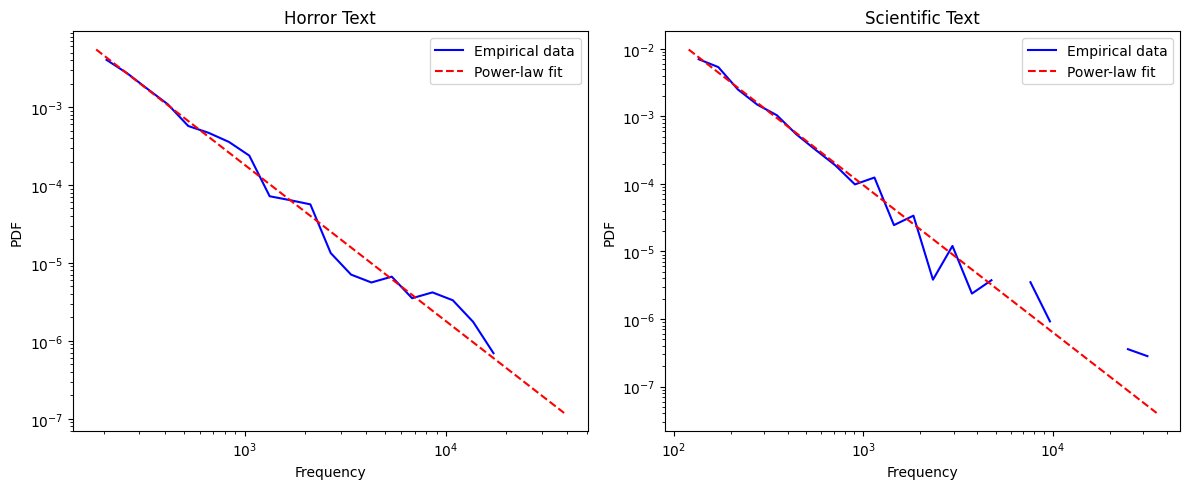

In [ ]:
# ======= Step 1: Create frequency lists =======
freqs_horror = rank_frequs(text_horror1)['frequency'].values
freqs_scientific = rank_frequs(text_scientific1)['frequency'].values

# ======= Step 2: Fit power-law =======
fit_horror = powerlaw.Fit(freqs_horror, discrete=True, verbose=False)
fit_scientific = powerlaw.Fit(freqs_scientific, discrete=True, verbose=False)

# ======= Step 3: Print stats =======
print("=== Horror Text ===")
print("Alpha:", fit_horror.power_law.alpha)
print("xmin:", fit_horror.power_law.xmin)
R1, p1 = fit_horror.distribution_compare('power_law', 'lognormal')
print("Log-likelihood ratio (R):", R1)
print("p-value:", p1)

print("\n=== Scientific Text ===")
print("Alpha:", fit_scientific.power_law.alpha)
print("xmin:", fit_scientific.power_law.xmin)
R2, p2 = fit_scientific.distribution_compare('power_law', 'lognormal')
print("Log-likelihood ratio (R):", R2)
print("p-value:", p2)

# ======= Step 4: Side-by-side plot =======
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot horror
fit_horror.plot_pdf(ax=axes[0], color='blue', label='Empirical data')
fit_horror.power_law.plot_pdf(ax=axes[0], color='red', linestyle='--', label='Power-law fit')
axes[0].set_title('Horror Text')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('PDF')
axes[0].legend()

# Plot scientific
fit_scientific.plot_pdf(ax=axes[1], color='blue', label='Empirical data')
fit_scientific.power_law.plot_pdf(ax=axes[1], color='red', linestyle='--', label='Power-law fit')
axes[1].set_title('Scientific Text')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('PDF')
axes[1].legend()

plt.tight_layout()
plt.show()

# Only values ≥ xmin are considered part of the power-law tail.
# Horror: xmin = 183
# Scientific: xmin = 120
# → Only words that occur 183 or more times (horror) or 120+ times (scientific) 
# are fitted by the power-law model.

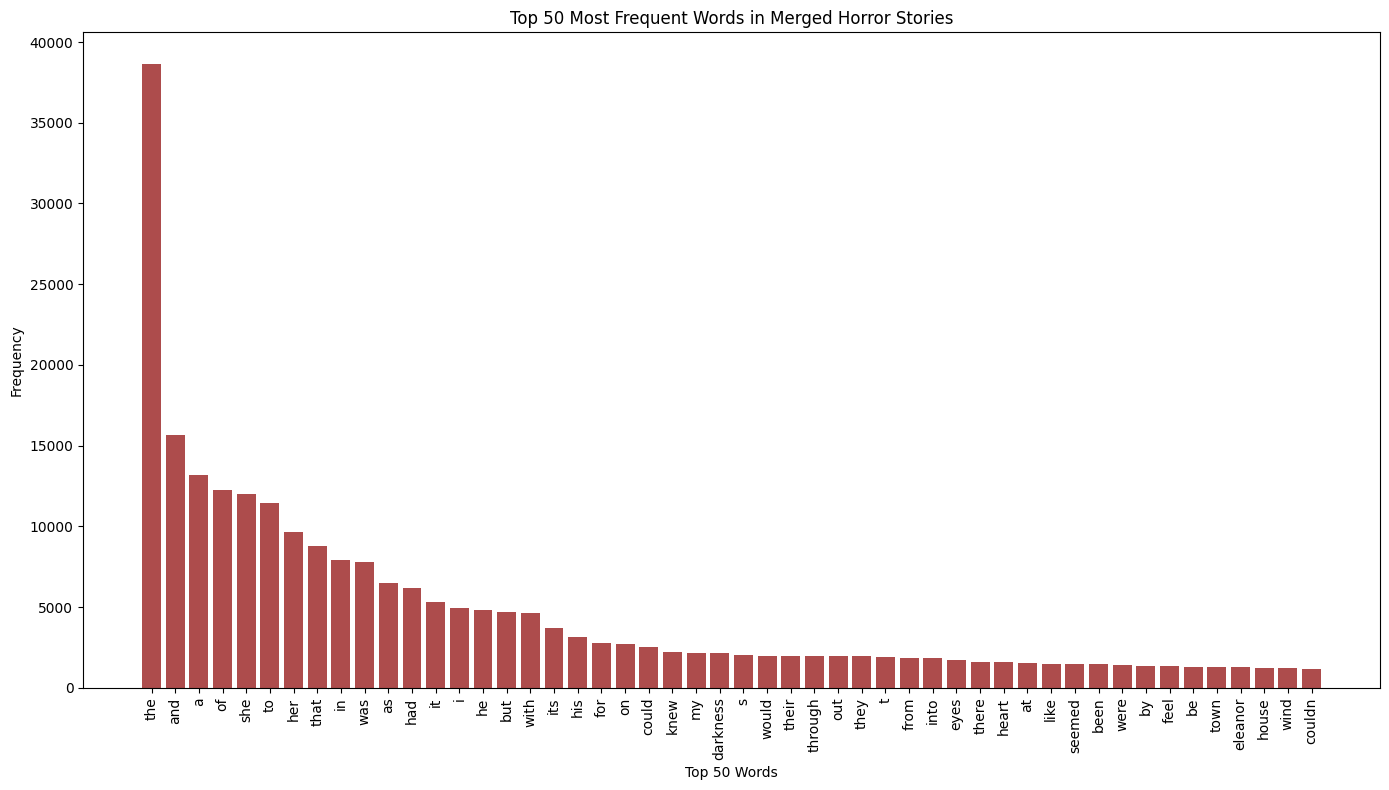

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get the frequency dataframe for the horror text
df_horror = rank_frequs(text_horror1)

# Select top 50 words by frequency
top_50 = df_horror.head(50).set_index('word')

# Create plot
y_pos = np.arange(len(top_50))
plt.figure(figsize=(14, 8))
plt.bar(y_pos, top_50['frequency'], align='center', alpha=0.7, color='darkred')
plt.xticks(y_pos, top_50.index, rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 Words')
plt.title('Top 50 Most Frequent Words in Merged Horror Stories')
plt.tight_layout()
plt.show()


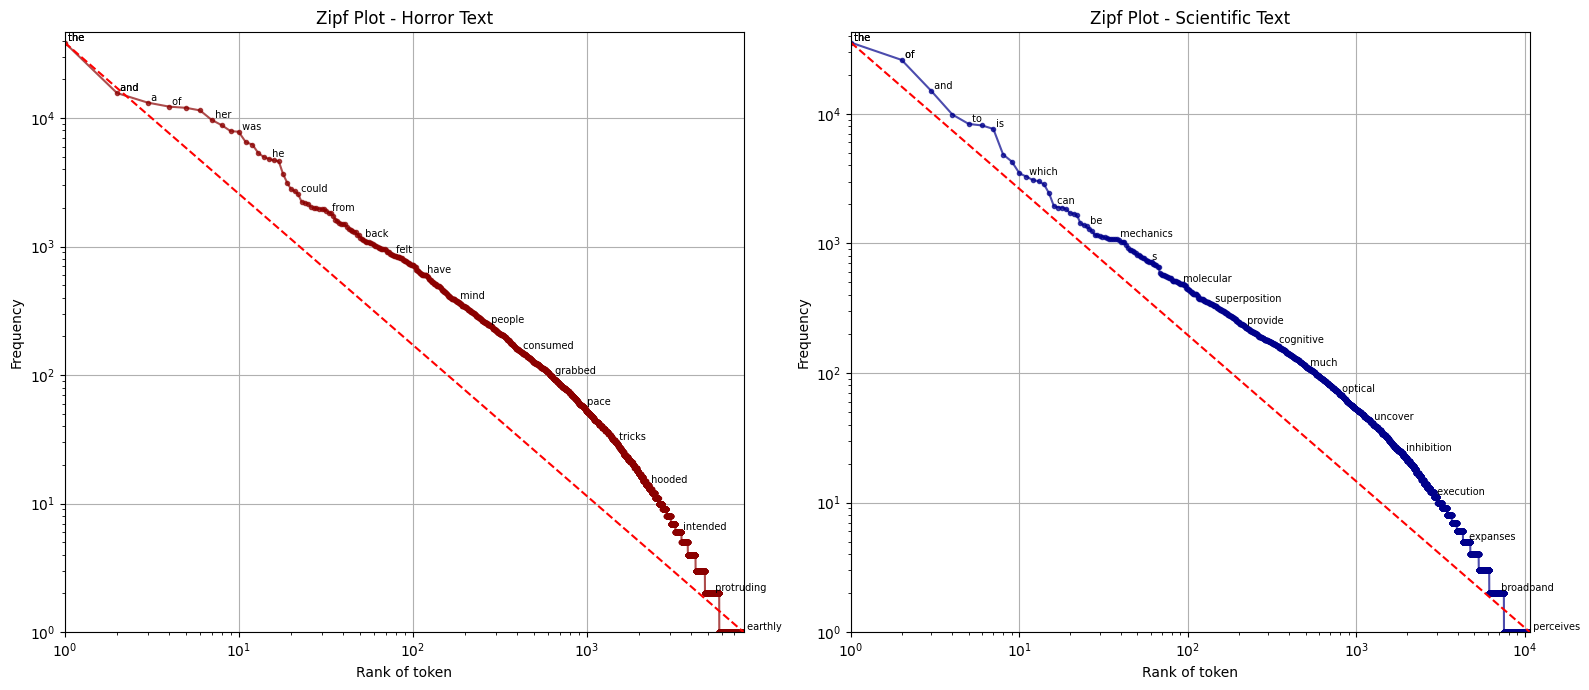

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import argsort, logspace

# Use your rank_frequs function to get frequency tables
df_horror = rank_frequs(text_horror1)
df_scientific = rank_frequs(text_scientific1)

def plot_zipf(df, ax, title_text, color='blue'):
    counts = df['frequency'].values
    tokens = df['word'].values
    ranks = np.arange(1, len(counts) + 1)
    indices = argsort(-counts)
    frequencies = counts[indices]

    ax.set_ylim(1, frequencies[0] * 1.2)
    ax.set_xlim(1, len(frequencies))
    ax.loglog(ranks, frequencies, marker=".", color=color, alpha=0.7)
    ax.plot([1, ranks[-1]], [frequencies[0], 1], color='red', linestyle='--')

    # Annotate ~25 tokens
    for n in list(logspace(-0.5, np.log10(len(counts) - 2), 25).astype(int)):
        ax.text(ranks[n], frequencies[n], " " + tokens[indices[n]],
                verticalalignment="bottom", horizontalalignment="left", fontsize=7)

    ax.set_title(title_text)
    ax.set_xlabel("Rank of token")
    ax.set_ylabel("Frequency")
    ax.grid(True)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

plot_zipf(df_horror, ax1, "Zipf Plot - Horror Text", color='darkred')
plot_zipf(df_scientific, ax2, "Zipf Plot - Scientific Text", color='darkblue')

plt.tight_layout()
plt.show()


USANDO RANK FREQUENCIES

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Apply your function
df_horror = rank_frequs(text_horror1)
df_scientific = rank_frequs(text_scientific1)


In [39]:
df_horror.tail()

,rank,word,frequency,rel_freq
7985,462,risks,1,0.000002
7986,462,kindling,1,0.000002
7987,462,lain,1,0.000002
7988,462,colliding,1,0.000002
7989,462,conclusion,1,0.000002


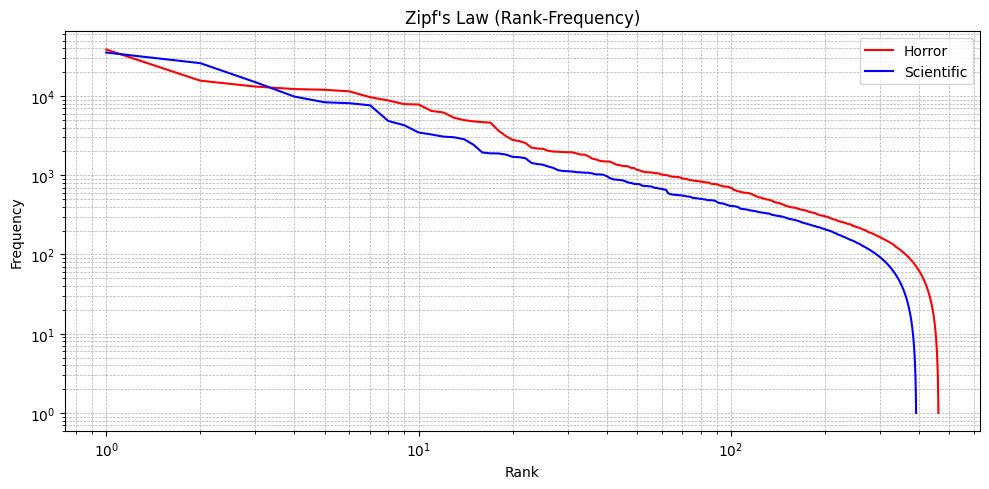

In [40]:
plt.figure(figsize=(10, 5))

# Horror
plt.loglog(df_horror['rank'], df_horror['frequency'], label='Horror', color='red')

# Scientific
plt.loglog(df_scientific['rank'], df_scientific['frequency'], label='Scientific', color='blue')

plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Zipf's Law (Rank-Frequency)")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
import powerlaw

fit_horror = powerlaw.Fit(df_horror['frequency'], discrete=True)
print("Suggested xmin horror:", fit_horror.power_law.xmin)

fit_scientific = powerlaw.Fit(df_scientific['frequency'], discrete=True)
print("Suggested xmin scientific:", fit_scientific.power_law.xmin)

Calculating best minimal value for power law fit
Suggested xmin horror: 183.0
Calculating best minimal value for power law fit
Suggested xmin scientific: 120.0


In [42]:
df_horror = df_horror[df_horror['frequency'] >= fit_horror.power_law.xmin]
df_scientific = df_scientific[df_scientific['frequency'] >= fit_scientific.power_law.xmin]

In [43]:
df_horror.tail()

,rank,word,frequency,rel_freq
356,282,oppressive,186,0.000384
357,283,fire,185,0.000382
358,284,determination,184,0.000380
359,285,opened,183,0.000378
360,285,laughter,183,0.000378


In [44]:
def estimate_zipf_alpha(df):
    log_r = np.log(df['rank'])
    log_f = np.log(df['frequency'])
    slope, intercept, r_value, p_value, std_err = linregress(log_r, log_f)
    return -slope, r_value**2  # Negative slope = Zipf α

alpha_horror, r2_horror = estimate_zipf_alpha(df_horror)
alpha_scientific, r2_scientific = estimate_zipf_alpha(df_scientific)

print("Horror Text:")
print("Estimated α (Zipf):", alpha_horror)
print("R²:", r2_horror)

print("\nScientific Text:")
print("Estimated α (Zipf):", alpha_scientific)
print("R²:", r2_scientific)


Horror Text:
Estimated α (Zipf): 1.0133011955981779
R²: 0.990263930864679

Scientific Text:
Estimated α (Zipf): 1.0135295825577983
R²: 0.9896019496044767


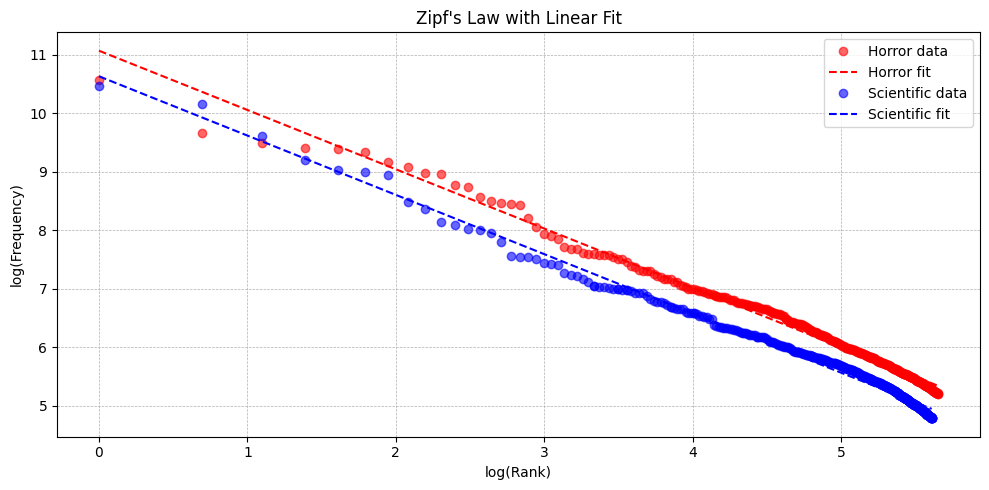

In [45]:
def plot_with_fit(df, label, color):
    log_r = np.log(df['rank'])
    log_f = np.log(df['frequency'])
    slope, intercept, *_ = linregress(log_r, log_f)
    plt.plot(log_r, log_f, 'o', label=f'{label} data', color=color, alpha=0.6)
    plt.plot(log_r, intercept + slope * log_r, '--', label=f'{label} fit', color=color)

plt.figure(figsize=(10, 5))
plot_with_fit(df_horror, 'Horror', 'red')
plot_with_fit(df_scientific, 'Scientific', 'blue')
plt.xlabel("log(Rank)")
plt.ylabel("log(Frequency)")
plt.title("Zipf's Law with Linear Fit")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()